In [249]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import time
%matplotlib inline

In [250]:
epochs = 5
batch_size = 50

In [251]:
# Each training data point will be length 100-1,
# since the last value in each sequence is the label
sequence_length = 100

# RNN AD
Q3. (75 points) Sometimes it is required to predict anomalies that occur in time series data. RNNs can be used to
predict anomalies in such time series data. In this question, you will predict anomalies in a time series data of an IoT
device utilization. When an anomalous observation occurs in such a time series, there will likely be a large deviation
between the predicted and observed series, because an anomalous event is often difficult to model. An example of
metric that can capture the extent of this deviation is a root mean square error (RMSE) plot between predictions and
observations. A large enough RMSE can be used to signal when anomalies occur. The dataset for this question is in
the file iot-util.csv. Starting from the notebook time-series.ipynb, fill out the missing code to create an RNN model
for predicting the time series, and detect anomalies in that series. Note that if your model is poor, you will end up with
more false positives, as well as false negatives. Note also that the threshold specified for anomaly detection in the
notebook has been empirically determined. Show your RMSE plot generated from the notebook as well as the times
at which your model detects the anomalies.

In [252]:
def generate_model():

    # RNN model
    model = tf.keras.models.Sequential([
        keras.layers.LSTM(256, input_shape=[99, 1], return_sequences=True),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.LSTM(16, return_sequences=True),
        keras.layers.LSTM(8),
        keras.layers.Dense(1)

    ])

    model.compile(optimizer='adam', loss='mse')

    model.summary()
    
    return model

In [253]:
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [254]:
def prepare_data(data, train_start, train_end, test_start, test_end):
    print("Length of Data", len(data))

    # training data
    print("Creating training data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Training data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Test data shape  : {}".format(result.shape))

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [255]:
def run(model=None, data=None):
    global_start_time = time.time()

    print('Loading data... ')
    data_b = pd.read_csv('iot-util.csv',
                         parse_dates=[0], infer_datetime_format=True)
    data = data_b['cpu'].to_numpy()

    # train on first 500 samples and test on last 160 samples (test set has anomaly)
    X_train, y_train, X_test, y_test = prepare_data(data, 0, 600, 400, 660)
    
    if model is None:
        model = generate_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, epochs=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test, verbose=1)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration:{}'.format(time.time() - global_start_time))
        return model, y_test, 0

    try:
        plt.figure(figsize=(20,8))
        plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        plt.plot(((y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print('Training duration:{}'.format(time.time() - global_start_time))

    return model, y_test, predicted

Loading data... 
Length of Data 660
Creating training data...
Training data shape  :  (500, 100)
Creating test data...
Test data shape  : (160, 100)
Shape X_train (500, 99)
Shape X_test (160, 99)


C:\Users\ptpsm\AppData\Local\Temp\ipykernel_26760\1529324510.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data_b = pd.read_csv('iot-util.csv',


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_127 (LSTM)             (None, 99, 256)           264192    
                                                                 
 lstm_128 (LSTM)             (None, 99, 128)           197120    
                                                                 
 lstm_129 (LSTM)             (None, 99, 64)            49408     
                                                                 
 lstm_130 (LSTM)             (None, 99, 32)            12416     
                                                                 
 lstm_131 (LSTM)             (None, 99, 16)            3136      
                                                                 
 lstm_132 (LSTM)             (None, 8)                 800       
                                                                 
 dense_28 (Dense)            (None, 1)               

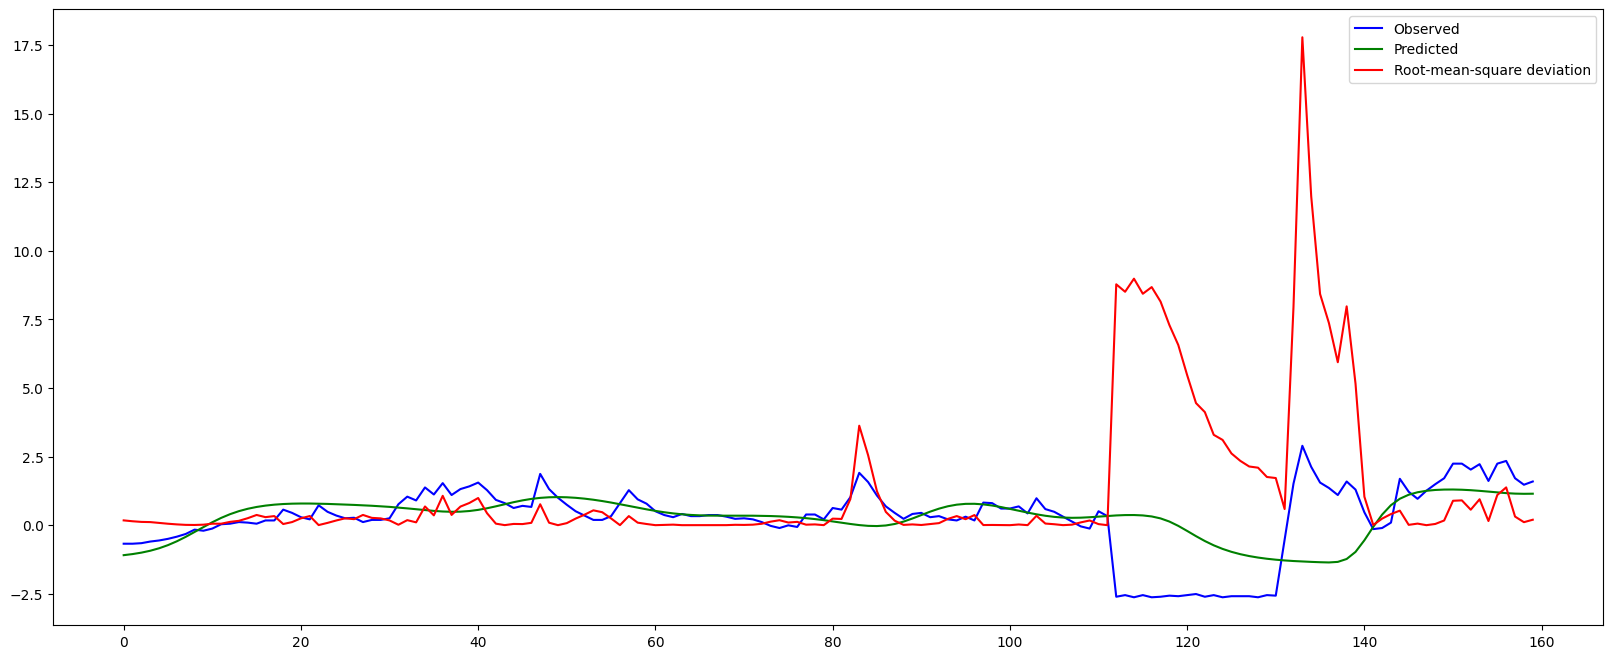

Training duration:8.421261310577393


In [256]:
model, y_test, predicted = run()

In [257]:
#anomaly threshold of 5 chosen based on empirical analyses
start_time = 0
threshold = 5
for i in range(0, len(predicted)-1):
    if ((y_test[i] - predicted[i]) ** 2) > threshold:
        print("Anomaly at time", start_time+i, "RMSE value:", (y_test[i] - predicted[i]) ** 2)
    i = i+1

Anomaly at time 112 RMSE value: 8.777010177029481
Anomaly at time 113 RMSE value: 8.505427900323742
Anomaly at time 114 RMSE value: 8.982002508541111
Anomaly at time 115 RMSE value: 8.43276942349171
Anomaly at time 116 RMSE value: 8.675888771793804
Anomaly at time 117 RMSE value: 8.147810533048949
Anomaly at time 118 RMSE value: 7.289538382617537
Anomaly at time 119 RMSE value: 6.56584665200375
Anomaly at time 120 RMSE value: 5.4697975866165365
Anomaly at time 132 RMSE value: 7.9486604536101355
Anomaly at time 133 RMSE value: 17.779064724993763
Anomaly at time 134 RMSE value: 11.982562390756748
Anomaly at time 135 RMSE value: 8.423620110038533
Anomaly at time 136 RMSE value: 7.363481539484599
Anomaly at time 137 RMSE value: 5.93728691779061
Anomaly at time 138 RMSE value: 7.973221759488861
Anomaly at time 139 RMSE value: 5.153357320903237
